The aim is to pass the images that we have to tensors, to be able to work later with a convolutional neural network.

In [1]:
# Import libraries
import torch # an open source ML library used for creating neural networks
from torch.utils.data import Dataset 
import os
from PIL import Image

In [2]:
# More imports
from torchvision.datasets import ImageFolder # to load the dataset
from torchvision import transforms # to transform the dataset (the images) 

import pytorch_lightning as pl  # to help to write more scalable and maintainable code
import torchmetrics #for evaluating and reporting metrics

# install torchmetrics
!pip install torchmetrics

In [3]:
# Read the dataset from the folder path = archive\OriginalDataset
dataset = ImageFolder(root = 'archive/OriginalDataset')

In [4]:
i, c = dataset[0] # i is the image and c is the class (label)

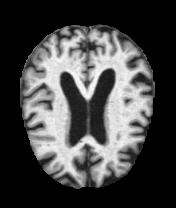

In [5]:
i # index of the first data point shown as an image

In [6]:
len(dataset) #we check the lenght of the dataset to see if it matches with the original that we used 

6400

In [7]:
# tensor (), normalize, 
transform1 = transforms.Compose([
    transforms.Resize((128, 128)), # resize the image to 128x128
    transforms.ToTensor(), # convert the image to a tensor
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]) # normalize the image with the mean and standard deviation of the ImageNet dataset
])

#apply transform1 to the dataset
dataset = ImageFolder(root = 'archive/OriginalDataset', transform = transform1) #loads the dataset from the original folder and applies the transform1 to it
i, c = dataset[0] #gets the first image and its label of the dataset, i is the image and c is the label
len(dataset) #check the length of the dataset to see if it matches with the previous one

6400

In [8]:
i # now i is shown as a tensor instead of an image

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

Once the data is organized correctly and the images have been converted to tensors, it is time to implement a CNN network with four classes (it uses three Conv2-ReLu-MaxPool layers and one sequential one)

In [9]:
# simple cnn model with 4 classes
class SimpleCNN(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.cnn = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(128 * 16 * 16, 4),
            torch.nn.Softmax(dim=-1)
        )
        self.accuracy = torchmetrics.Accuracy('multiclass', num_classes=4)
        
    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_accuracy', self.accuracy(y_hat, y), on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
    
    

In [10]:
# train the model
model = SimpleCNN()
trainer = pl.Trainer(accelerator = "gpu", max_epochs=10) # use GPU, 10 epochs
trainer.fit(model)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\piqui\anaconda3\envs\Ai\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type               | Params
------------------------------------------------
0 | cnn      | Sequential         | 93.2 K
1 | fc       | Sequential         | 131 K 
2 | accuracy | MulticlassAccuracy | 0     
--------------

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.
